In [27]:
import os
import random
import numpy as np
import pandas as pd
import sys
import sklearn
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize , word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
import gensim
from nltk.stem import *
from gensim.utils import simple_preprocess
from nltk.stem import WordNetLemmatizer 
from gensim.corpora import Dictionary
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from nltk import word_tokenize
from pprint import pprint
from nltk.corpus import stopwords
from sklearn import cluster
from summa import keywords
from gensim.models import Nmf

In [8]:
df_speech=pd.read_csv('obama_clean.csv')

In [60]:
# Use Gensim's NMF to get the best num of topics via coherence score
texts = [text.split() for text in df_speech['clean_content'].values]

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(4, 24, 2))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        passes=20,
        kappa=.5,
        #minimum_probability=0.001,
        w_max_iter=500,
        h_max_iter=100,
        normalize=True,
        random_state=0
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))

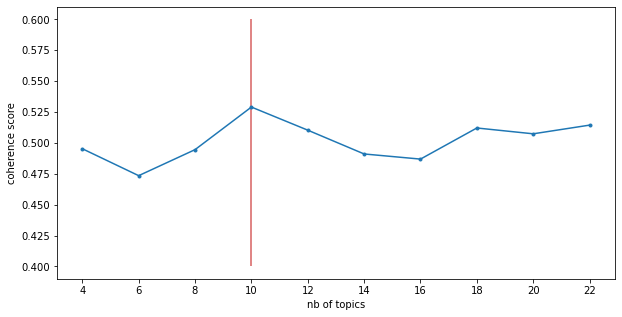

In [69]:
fig, ax = plt.subplots()
ax.plot(topic_nums, coherence_scores, '.-')
ax.set_xlabel('nb of topics')
ax.set_ylabel('coherence score');
ymin = 0.4
ymax = 0.6
plt.xticks(range(2,24,2))
plt.vlines(x=10, ymin=ymin, ymax=ymax, color='r')
plt.show()

In [54]:
vec_nmf=TfidfVectorizer(min_df=50)
X_nmf=vec_nmf.fit_transform(df_speech['clean_content'])
model_nmf=NMF(n_components=10, random_state=5)
model_nmf.fit(X_nmf)
nmf_feature=model_nmf.transform(X_nmf)

nmf_df = pd.DataFrame(model_nmf.components_, columns=vec_nmf.get_feature_names())
nmf_df.head()   

,abide,ability,abroad,absolutely,abuse,accept,access,accomplish,account,accountability,...,worst,worth,wound,write,wrong,year,yesterday,york,young,youth
0,0.015945,0.071123,0.051127,0.004887,0.022975,0.032182,0.065640,0.002105,0.016158,0.031527,...,0.010987,0.010549,0.000000,0.021903,0.006601,0.117799,0.032777,0.006833,0.243402,0.051054
1,0.000000,0.010279,0.007926,0.016804,0.009323,0.025822,0.040474,0.006689,0.010994,0.014944,...,0.028402,0.033095,0.000000,0.019821,0.021340,0.163422,0.000000,0.010610,0.040702,0.000000
2,0.000791,0.015535,0.007875,0.000000,0.010039,0.034045,0.003608,0.009403,0.014802,0.000000,...,0.026889,0.016515,0.058829,0.086168,0.040701,0.175629,0.006825,0.029149,0.153158,0.033001
3,0.000244,0.005743,0.006825,0.010065,0.000000,0.001214,0.000000,0.005683,0.008656,0.000000,...,0.004049,0.000000,0.000000,0.000000,0.000000,0.028618,0.000000,0.010267,0.000000,0.000135
4,0.037133,0.040478,0.000000,0.065130,0.011949,0.010759,0.044324,0.051822,0.017037,0.004596,...,0.008080,0.018966,0.000000,0.015745,0.029988,0.192191,0.042401,0.013625,0.181422,0.006628


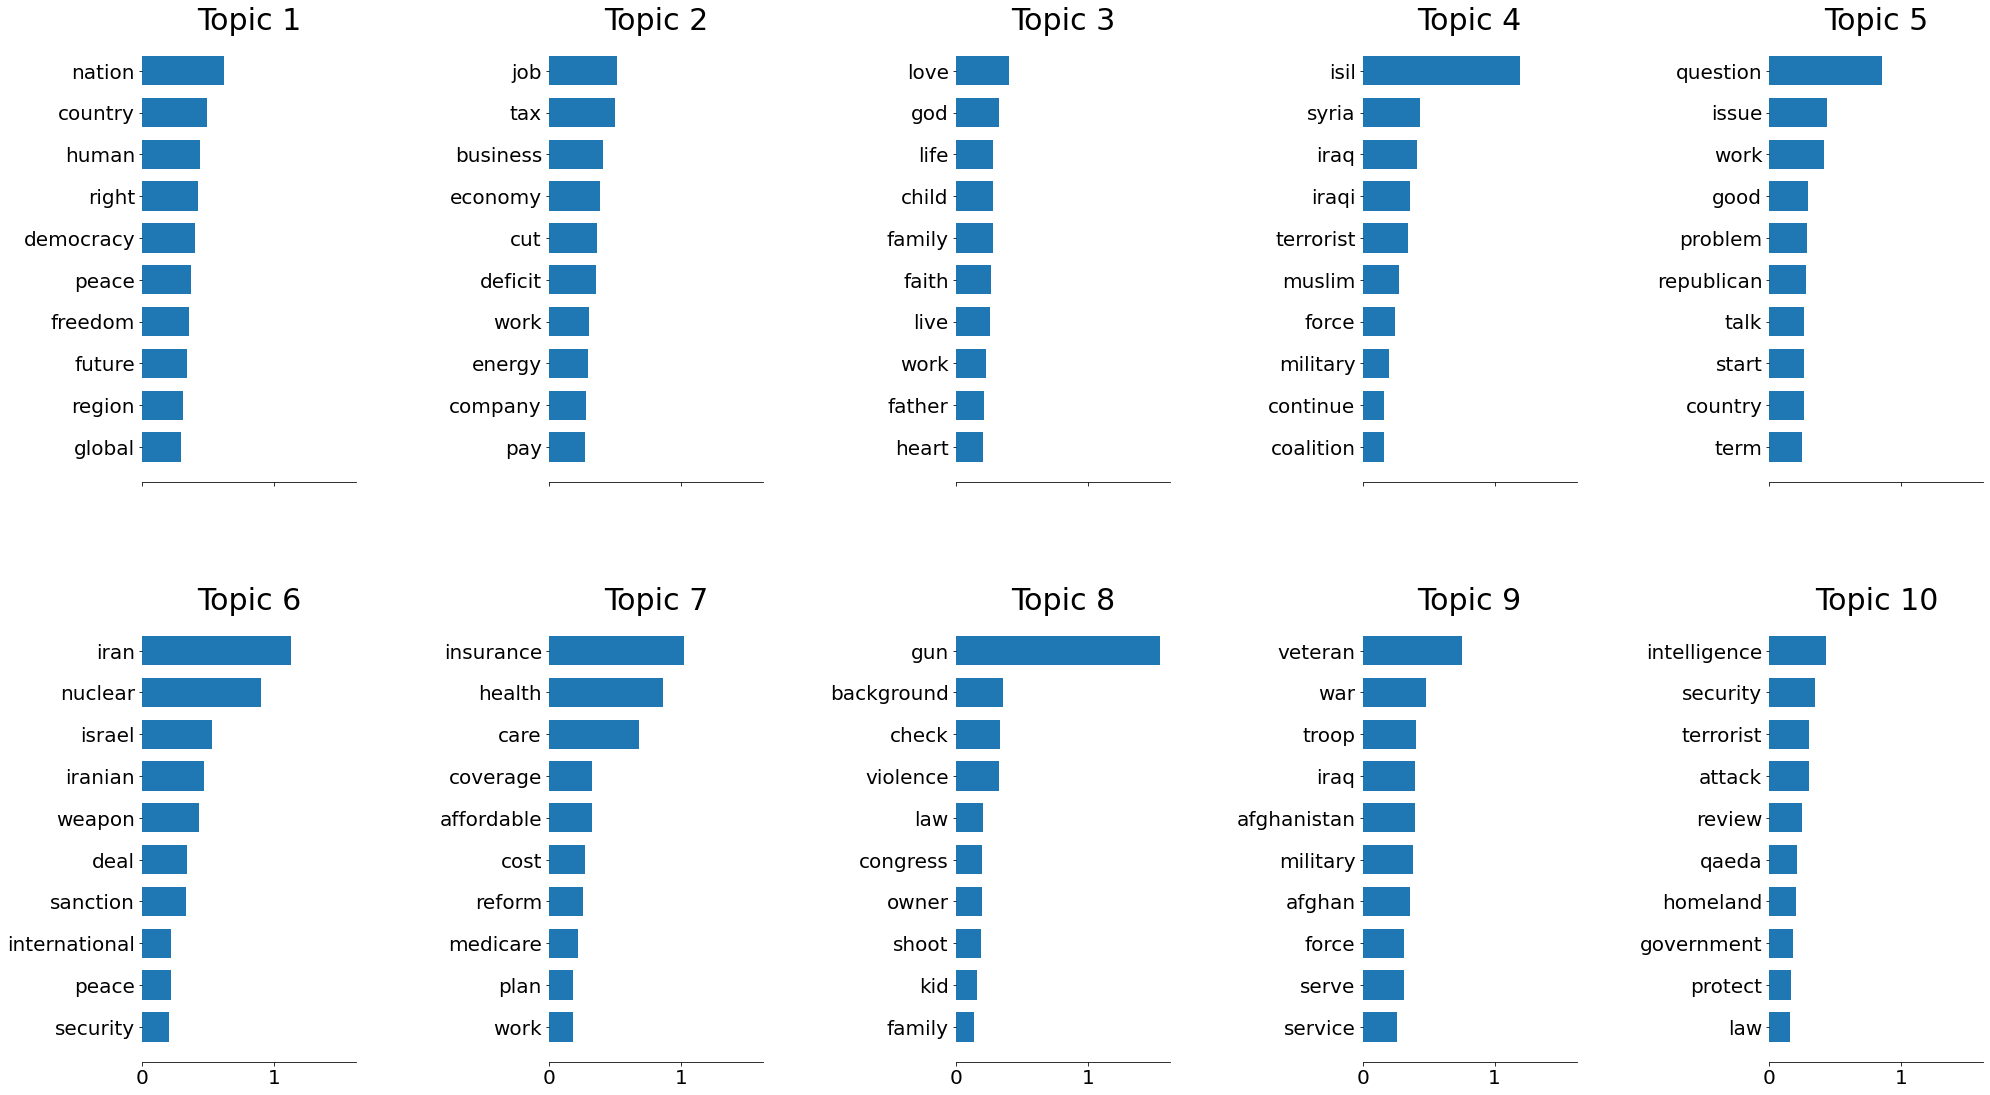

In [55]:
def plot_top_words(model, feature_names, n_top_words):
    fig, axes = plt.subplots(2, 5, figsize=(33, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        #fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=1, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

plot_top_words(
    model_nmf,
    vec_nmf.get_feature_names(),
    10)   

In [56]:
topic_doc=pd.DataFrame(nmf_feature).idxmax(axis=1).value_counts()
df=pd.DataFrame()
df['topic']=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
df['topic_num']=topic_doc

In [58]:
topic_dist=pd.DataFrame(nmf_feature)
top_4=[]

for topic_idx, topic in enumerate(model_nmf.components_):
        top_4_ind = (-topic).argsort()[:4]
        top_4.append([vec_nmf.get_feature_names()[i] for i in top_4_ind])
topic_dist.columns=[" ".join(topic) for topic in top_4]

df_speech['date'] = pd.to_datetime(df_speech['date'])
df_speech['year'] = pd.DatetimeIndex(df_speech['date']).year

topic_dist=pd.concat([df_speech, topic_dist], axis=1)
topic_dist['month'] = topic_dist['date'].dt.to_period('M')
topic_dist['Date (by month)'] = [month.to_timestamp() for month in topic_dist['month']]
topic_dist=topic_dist.set_index('Date (by month)')

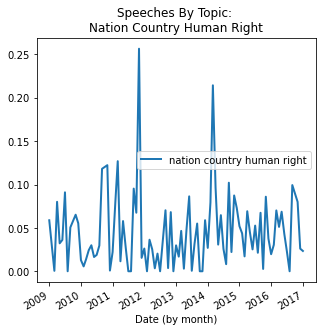

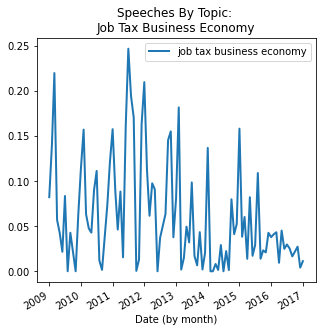

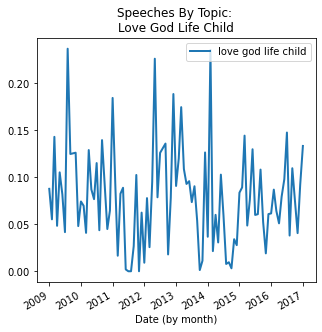

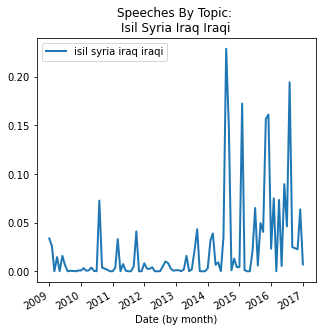

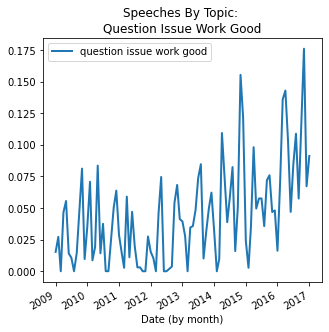

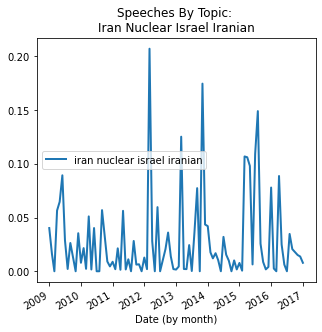

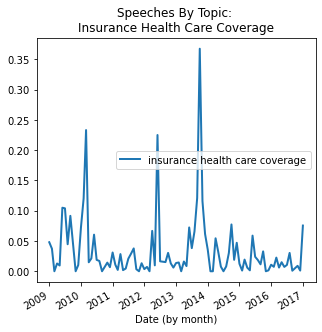

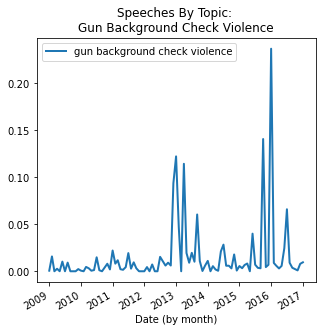

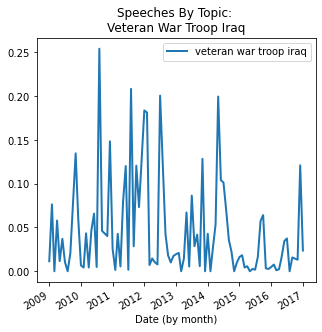

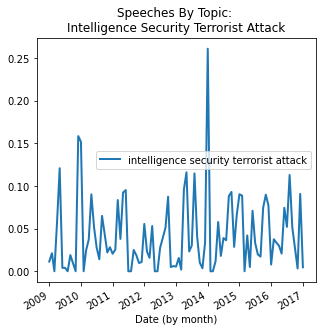

In [70]:
plt.rcParams['figure.figsize'] = [5, 5]
for i in range(len(top_4)):
    topic_label = " ".join(top_4[i][:4])
    topic_dist.groupby(topic_dist.index)[[topic_label]].mean().plot(title=f'Speeches By Topic: \n{topic_label.title()}', linewidth=2)